In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Setup Mediapipe Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

### Extract Landmark Function

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

## Setup Folders Dataset and Class (actions)

In [6]:
path = os.getcwd()
DATA_PATH = os.path.join('Dataset') 

# Action Lists
actions = np.array(['halo', 'apa kabar', 'aku', 'kamu', 'maaf', 'tolong', 'ya', 'tidak', 'suka', 'makanan', 
                    'selamat pagi', 'selamat siang', 'selamat sore', 'selamat malam', 'sampai jumpa lagi', 
                    'perkenalkan', 'terima kasih', 'sama-sama', 'mau', 'tidak mau'])

## Preprocess Data and Create Labels and Features

In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

### Mapping Label

In [55]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'halo': 0,
 'apa kabar': 1,
 'aku': 2,
 'kamu': 3,
 'maaf': 4,
 'tolong': 5,
 'ya': 6,
 'tidak': 7,
 'suka': 8,
 'makanan': 9,
 'selamat pagi': 10,
 'selamat siang': 11,
 'selamat sore': 12,
 'selamat malam': 13,
 'sampai jumpa lagi': 14,
 'perkenalkan': 15,
 'terima kasih': 16,
 'sama-sama': 17,
 'mau': 18,
 'tidak mau': 19}

### Specify Number of Sequence and Sequence Length

In [56]:
# num videos worth of data
no_sequences = 60

# Videos are going to be num frames in length
sequence_length = 30

### Implement Time-series Data Augmmentation

In [57]:
import random
from scipy.interpolate import interp1d

# Define augmentation functions
def time_warp(sequence, sigma=0.2):
    """Randomly warps a time-series sequence."""
    num_frames = len(sequence)
    time_stamps = np.arange(num_frames)
    
    # Generate a smooth random warping function
    random_offsets = np.random.normal(0, sigma, size=num_frames)
    warped_time = time_stamps + random_offsets
    warped_time = np.clip(warped_time, 0, num_frames - 1)

    # Interpolate to align with original timestamps
    interp_func = interp1d(warped_time, sequence, axis=0, kind='linear', fill_value="extrapolate")
    return interp_func(time_stamps)

def jitter(sequence, noise_level=0.02):
    """Adds Gaussian noise to a sequence."""
    return sequence + np.random.normal(0, noise_level, sequence.shape)

def scaling(sequence, sigma=0.1):
    """Scales the sequence randomly."""
    scale_factor = np.random.normal(1, sigma)
    return sequence * scale_factor

def time_masking(sequence, mask_ratio=0.1):
    """Randomly masks some frames to zero."""
    num_frames = len(sequence)
    mask_indices = np.random.choice(num_frames, int(mask_ratio * num_frames), replace=False)
    sequence[mask_indices] = 0
    return sequence

### Prepocessing Normal Sequence

In [58]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        
        window = np.array(window)

        # Apply random augmentations
        if random.random() < 0.5:  # 50% chance to apply augmentation
            choice = random.choice([time_warp, jitter, scaling, time_masking])
            window = choice(window)

        sequences.append(window)
        labels.append(label_map[action])

In [59]:
X = np.array(sequences)
X.shape

(1200, 30, 258)

In [60]:
y = to_categorical(labels, num_classes=len(actions))  # Shape: (num_frames, num_classes)
y.shape

(1200, 20)

### Preprocessing Windowed Sequence

In [33]:
# Hyperparameters
WINDOW_SIZE = 10  # Number of frames in each input window
STRIDE = 5  # Shift of the window

X = []  # Store sequences
y = []  # Store labels

for action in actions:  # Iterate through action labels
    action_path = os.path.join(DATA_PATH, action)
    
    for iteration in os.listdir(action_path):
        iteration_path = os.path.join(action_path, iteration)
        frames = []
        
        for frame_file in sorted(os.listdir(iteration_path)):  # Ensure correct order
            frame_path = os.path.join(iteration_path, frame_file)
            frame_data = np.load(frame_path)  # Shape (258,)
            frames.append(frame_data)
        
        # Apply sliding window
        num_frames = len(frames)
        for start in range(0, num_frames - WINDOW_SIZE + 1, STRIDE):
            window = np.array(frames[start:start + WINDOW_SIZE])  # Extract window
            
            # Apply random augmentation (50% probability)
            if random.random() < 0.5:
                choice = random.choice([time_warp, jitter, scaling, time_masking])
                window = choice(window)

            X.append(window)  # Shape: (WINDOW_SIZE, 258)
            y.append(label_map[action])  # Map action label to number

X = np.array(X)  # Shape: (num_windows, WINDOW_SIZE, 258)
y = np.array(y)  # Shape: (num_windows,)

In [34]:
X.shape

(6000, 10, 258)

In [35]:
y.shape

(6000,)

In [36]:
y = to_categorical(y, num_classes=len(actions))  # Shape: (num_windows, num_classes)
y.shape

(6000, 20)

### Train Test Split

In [61]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Check the shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (960, 30, 258), Validation: (120, 30, 258), Test: (120, 30, 258)


## Build and Train LSTM Neural Network

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

### Model for Normal Sequence

In [63]:
model = Sequential()

# LSTM Layers
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, 258)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(actions.shape[0], activation='softmax'))

### Model for Windowed Sequece

In [39]:
model = Sequential()
# LSTM Layers
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(10, 258)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) 

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(len(actions), activation='softmax'))

## Training Process

In [64]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val), 
    epochs=300,  
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
30/30 [==============================] - 26s 198ms/step - loss: 2.9378 - categorical_accuracy: 0.0865 - val_loss: 2.7162 - val_categorical_accuracy: 0.1167 - lr: 0.0010
Epoch 2/300
30/30 [==============================] - 3s 102ms/step - loss: 2.7236 - categorical_accuracy: 0.1281 - val_loss: 2.6810 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 3/300
30/30 [==============================] - 3s 104ms/step - loss: 2.6614 - categorical_accuracy: 0.1948 - val_loss: 2.5540 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 4/300
30/30 [==============================] - 3s 106ms/step - loss: 2.6910 - categorical_accuracy: 0.1594 - val_loss: 2.5700 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 5/300
30/30 [==============================] - 3s 100ms/step - loss: 2.4870 - categorical_accuracy: 0.2083 - val_loss: 2.2841 - val_categorical_accuracy: 0.2583 - lr: 0.0010
Epoch 6/300
30/30 [==============================] - 3s 109ms/step - loss: 2.4398 - categorical_acc

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 128)           198144    
                                                                 
 lstm_7 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 20)                660       
                                                                 
Total params: 287476 (1.10 MB)
Trainable params: 28747

## Make Predictions

In [67]:
res = model.predict(X_test)

4/4 [==============================] - 5s 64ms/step


In [68]:
actions[np.argmax(res[6])]

'suka'

In [69]:
actions[np.argmax(y_test[6])]

'suka'

## Save Model

In [75]:
model.save('Models/model_normal_seq_5.h5')

d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
model.load_weights('Models/model_normal_seq_5.h5')

## Evaluation using Confusion Matrix and Accuracy

In [70]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [71]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

4/4 [==============================] - 0s 65ms/step


array([[[113,   1],
        [  2,   4]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[113,   1],
        [  1,   5]],

       [[112,   2],
        [  0,   6]],

       [[112,   2],
        [  0,   6]],

       [[114,   0],
        [  2,   4]],

       [[113,   1],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[113,   1],
        [  1,   5]],

       [[113,   1],
        [  1,   5]],

       [[114,   0],
        [  2,   4]],

       [[113,   1],
        [  0,   6]],

       [[114,   0],
        [  1,   5]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  0,   6]],

       [[114,   0],
        [  1,   5]],

       [[114,   0],
        [  0,   6]],

       [[113,   1],
        [  0,   6]]], dtype=int64)

In [72]:
accuracy_score(ytrue, yhat)

0.9083333333333333

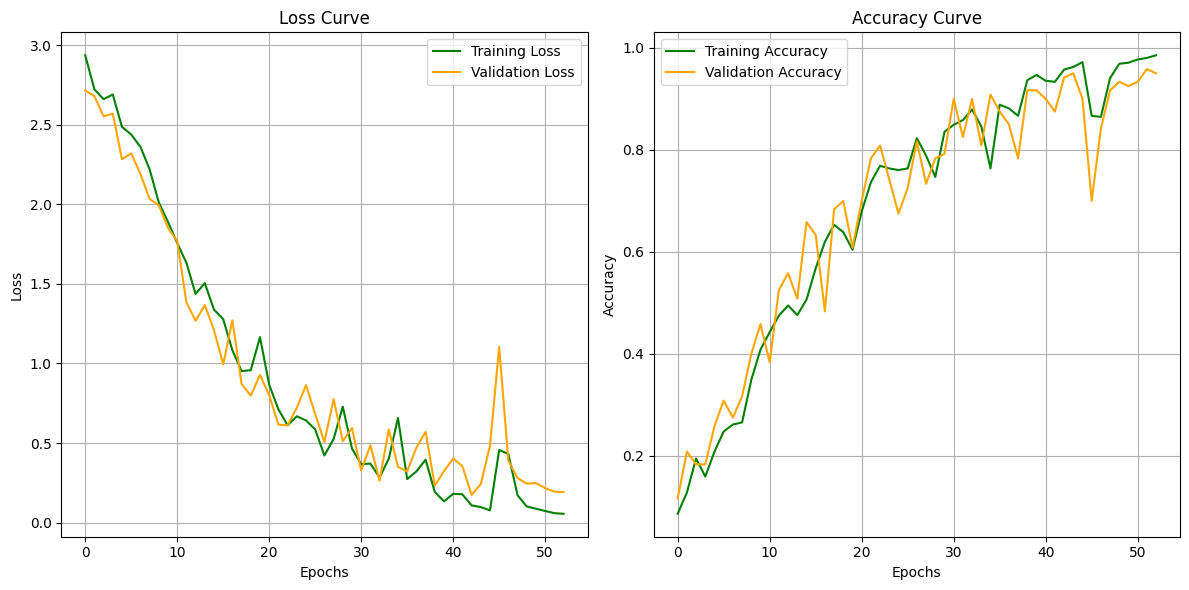

In [73]:
# Plot training loss and training accuracy
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

# Plotting validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

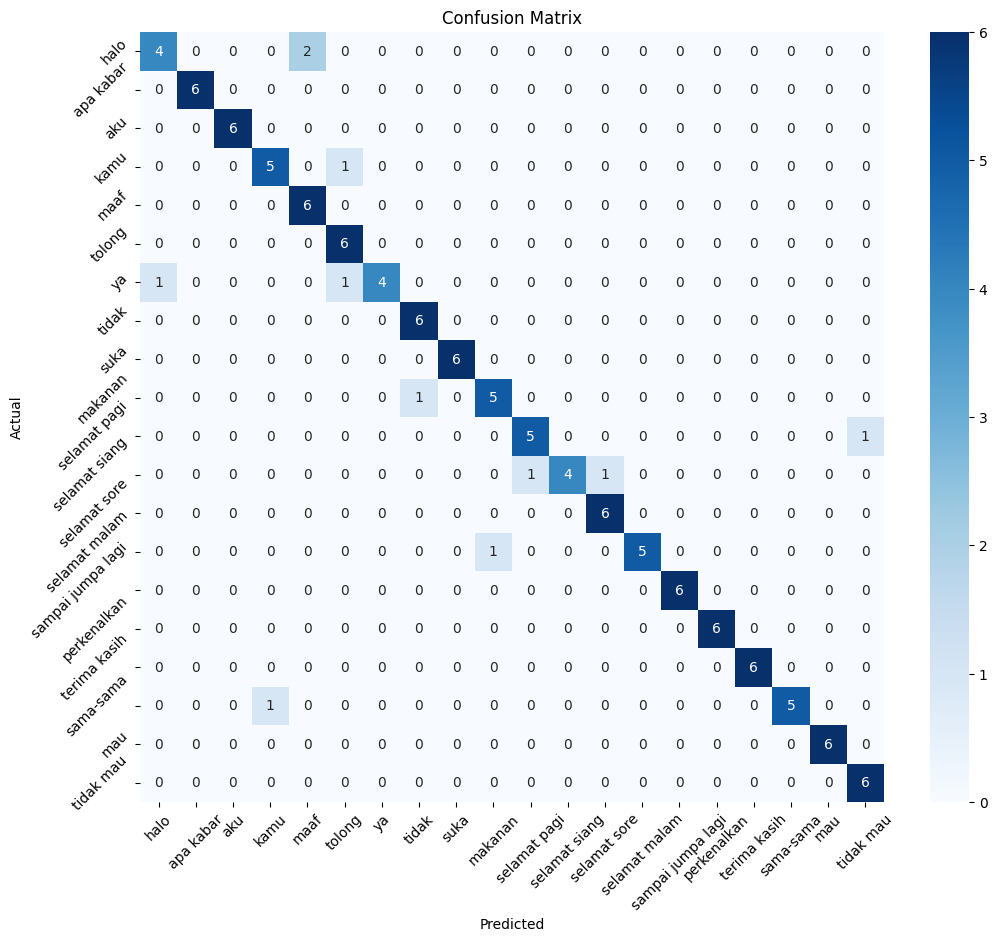


Precision: 0.9185714285714286
Recall: 0.9083333333333333
F1 Score: 0.9064485514485514

Classification Report:
                    precision    recall  f1-score   support

             halo       0.80      0.67      0.73         6
        apa kabar       1.00      1.00      1.00         6
              aku       1.00      1.00      1.00         6
             kamu       0.83      0.83      0.83         6
             maaf       0.75      1.00      0.86         6
           tolong       0.75      1.00      0.86         6
               ya       1.00      0.67      0.80         6
            tidak       0.86      1.00      0.92         6
             suka       1.00      1.00      1.00         6
          makanan       0.83      0.83      0.83         6
     selamat pagi       0.83      0.83      0.83         6
    selamat siang       1.00      0.67      0.80         6
     selamat sore       0.86      1.00      0.92         6
    selamat malam       1.00      0.83      0.91         6
sa

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# Convert predictions & labels to integer class indices
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(res, axis=1).tolist()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels for the heatmap
class_labels = list(label_map.keys())  # Get sign language action labels

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Precision, Recall, F1-Score, and accuration
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))